In [11]:
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
library(parallel)
library(ggpubr)
library(rstatix)
library(parallel)
library(ggpubr)
library(anndata)
library(ggsci)
library(ggrepel)
library(patchwork)
library(pheatmap)
library(aplot)

# LMM result

In [6]:
file_list<-list.files(path ='/home//jupyter/BRI_Analysis/scRNA/Analysis-Longitudinal_Baselines/04C_LMM_Time', pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)

In [7]:
LMM_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))
LMM_res<-do.call(rbind,LMM_list) %>%
  filter(factor == 'sample.daysSinceFirstVisit') %>%
  group_by(celltype) %>%
  mutate(padj = p.adjust(`Pr...t..`, method = 'BH')) 
LMM_res$p.normal<-LMM_res$`Pr...t..`


In [8]:
LMM_res$Estimate<-as.numeric(LMM_res$Estimate)

In [13]:
write.csv( as.data.frame(table(LMM_res$celltype)) %>% arrange(desc(Freq)),'temp.csv')

In [8]:
write.csv(LMM_res,'lmm_res_aging.csv')

In [37]:
Plot_list<-list()
for (i in 1:length(unique(LMM_res$celltype))){

data <- LMM_res %>% filter(celltype==unique(LMM_res$celltype)[i])%>% mutate(Expression = case_when(Estimate >0 & padj <=  0.05 ~ "Up-regulated_along_time",
                                                     Estimate < 0 & padj <=  0.05 ~ "Down-regulated_along_time",
                                                     TRUE ~ "Unchanged"))
top <- 20
top_genes <- bind_rows(
  data %>% 
    filter(Expression == 'Up-regulated_along_time') %>% 
    arrange(padj, desc(abs(Estimate))) %>% 
    head(top),
  data %>% 
    filter(Expression == 'Down-regulated_along_time') %>% 
    arrange(padj, desc(abs(Estimate))) %>% 
    head(top)
)
    
Plot_list[[unique(LMM_res$celltype)[i]]]<-ggplot(data, aes(Estimate, -log(padj,10))) +
  geom_point(aes(color = Expression), size =0.1) +
  xlab(expression("Estimate")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated_along_time"="dodgerblue3", "Unchanged"="gray50", "Up-regulated_along_time"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=8))) +
  geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=15,

                   mapping = aes(Estimate, -log(padj,10), label = Gene),
                   size = 3)+ ggtitle(unique(LMM_res$celltype)[i])+theme_bw(base_size=11)

}

Warning message:
“ggrepel: 37 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 39 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 38 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 38 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 19 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 33 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 23 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


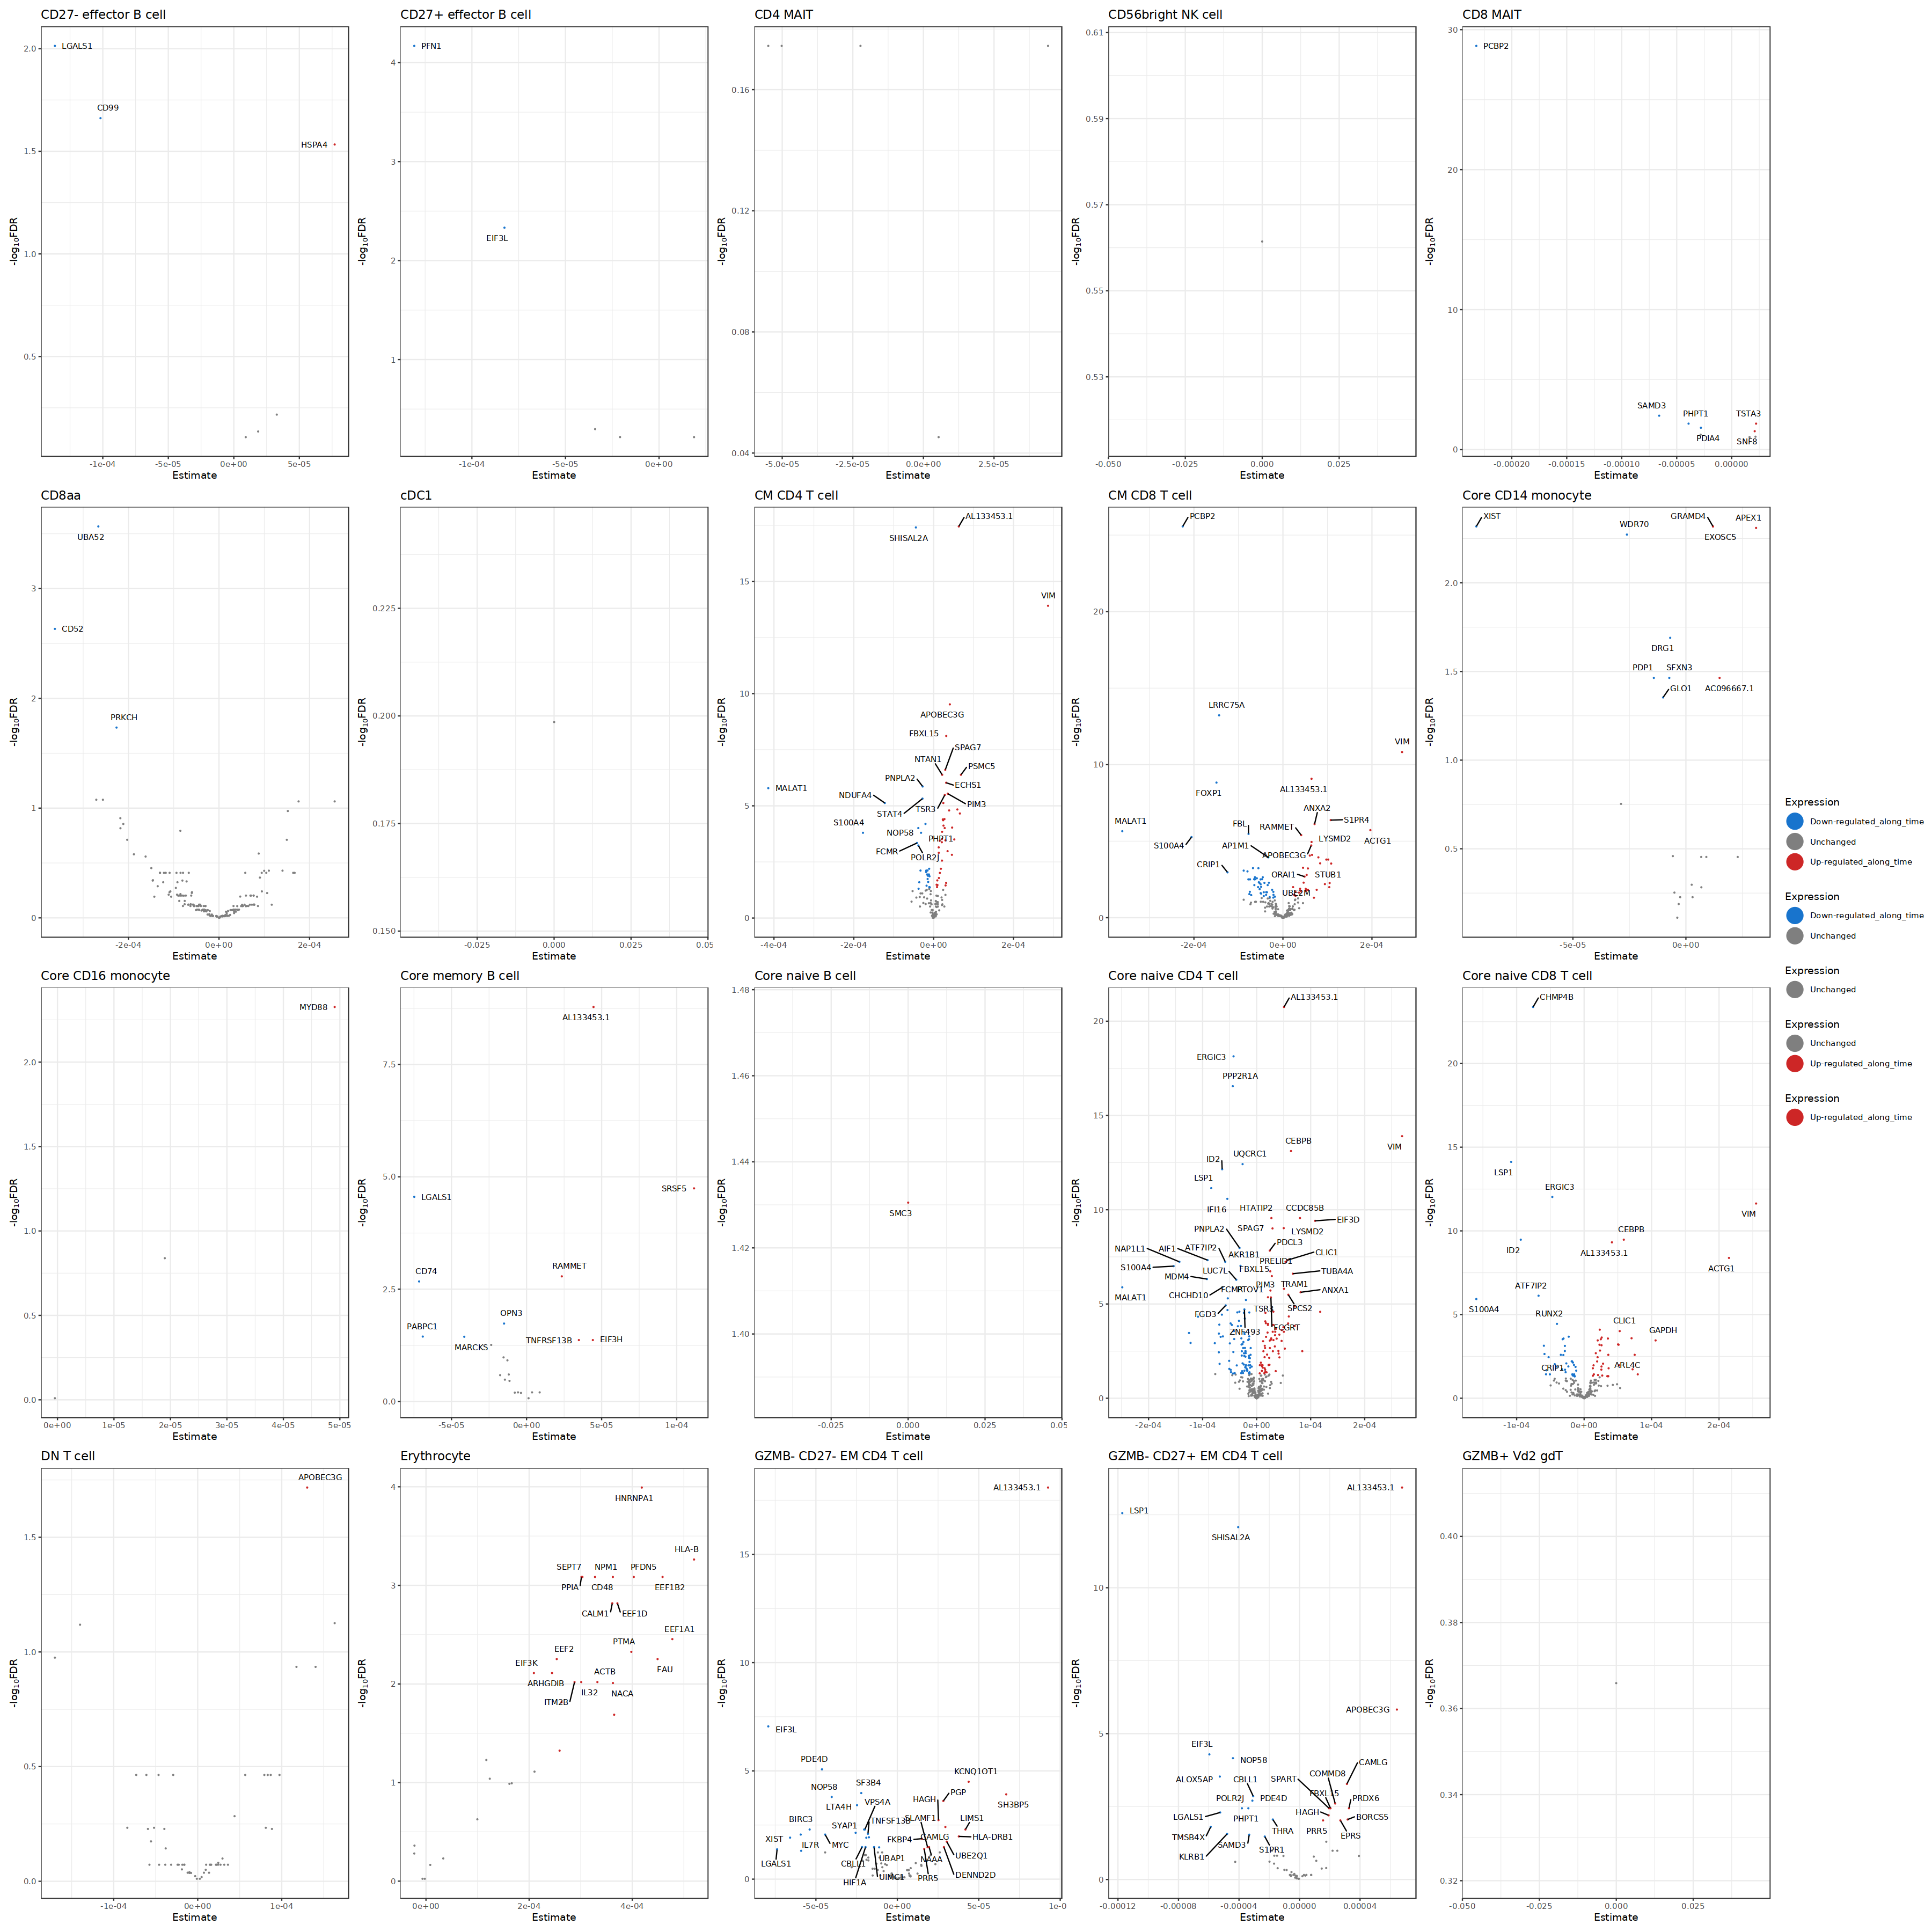

In [38]:
options(repr.plot.width = 30, repr.plot.height = 30)

wrap_plots(Plot_list[1:20],ncol=5)+ plot_layout(guides = "collect")

Warning message:
“ggrepel: 26 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 40 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 14 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


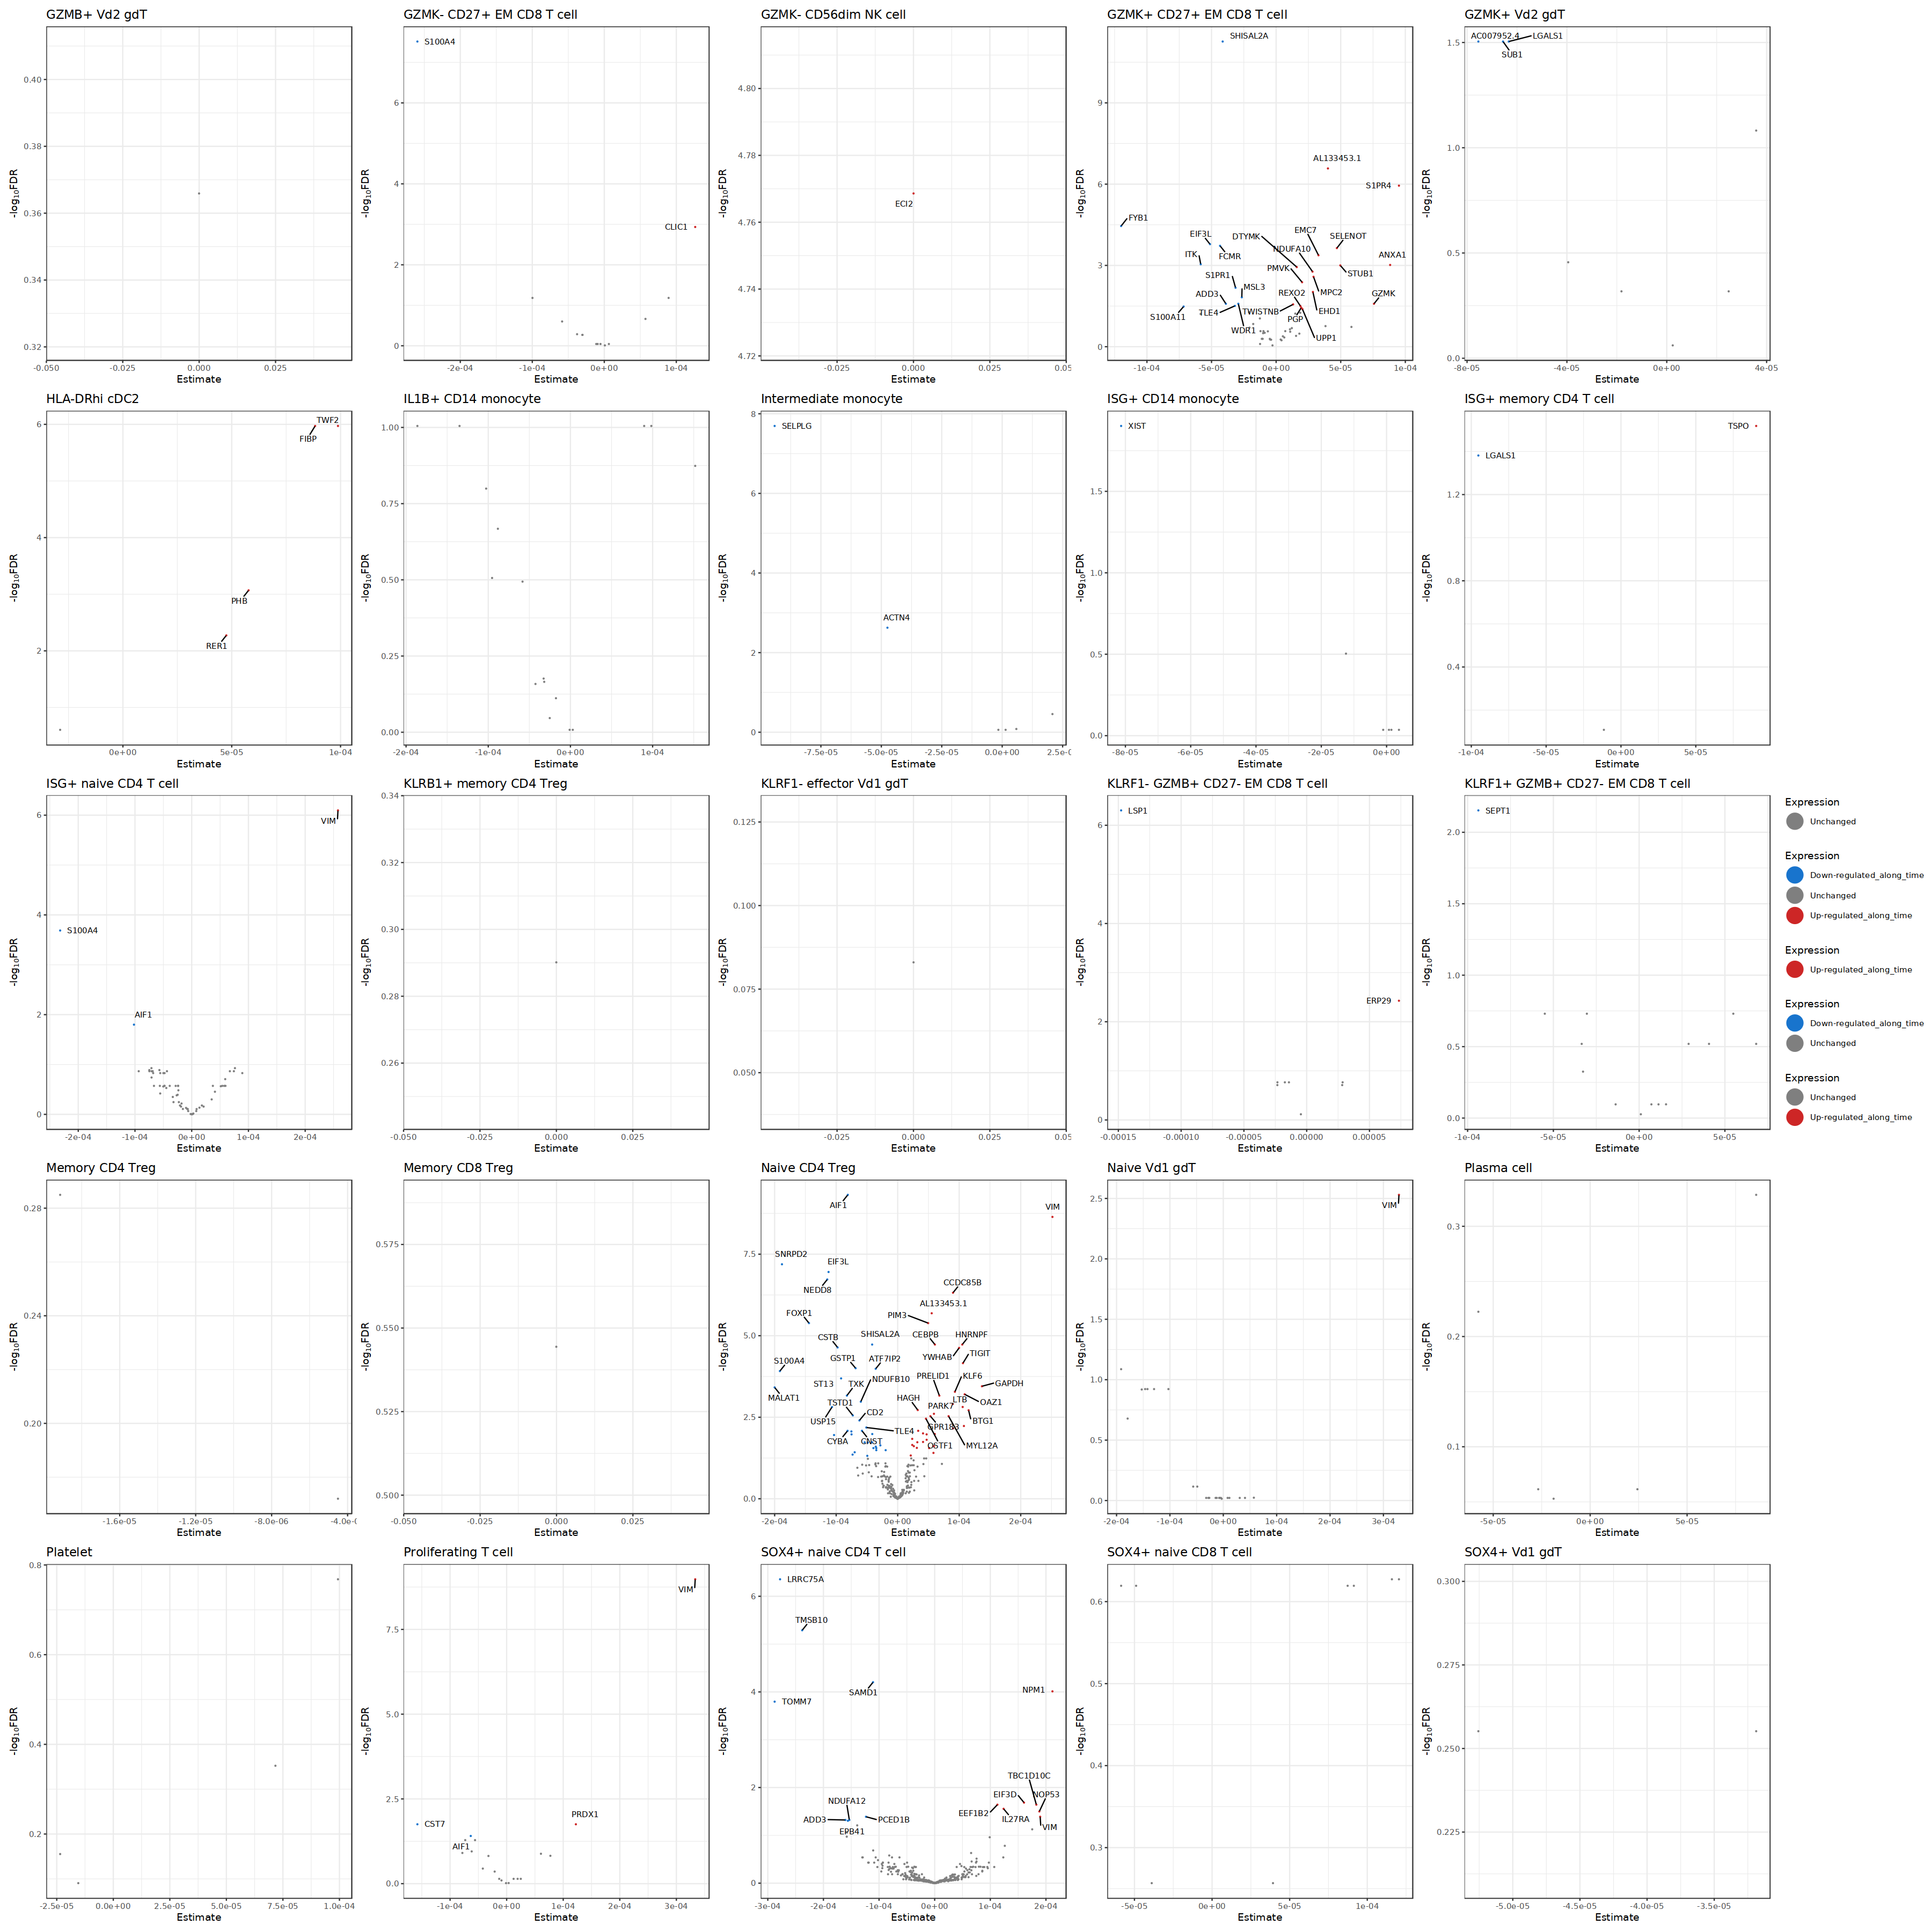

In [39]:
options(repr.plot.width = 30, repr.plot.height = 30)

wrap_plots(Plot_list[20:length(Plot_list)],ncol=5)+ plot_layout(guides = "collect")

# DEG log2fc correlation

In [1]:
file_list<-list.files(path ='/home//jupyter/BRI_Analysis/scRNA/Analysis-Cross-Sectional/02B_DESeq2_BR1_VS_BR2_L3', pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)

In [41]:
DEG_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))

DEG<-do.call(rbind,DEG_list)


In [42]:
DEG<- DEG%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <=  0.05 ~ "Up-regulated-BR1",
                                                     log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated-BR1",
                                                     TRUE ~ "Unchanged"))

In [43]:
DEG_filtered<-DEG %>% filter(!Expression=='Unchanged')

In [ ]:
meta_data_nonD7<-meta_data  %>% filter(!sample.visitName %in% c('Flu Year 1 Day 7','Flu Year 2 Day 7'))

In [47]:
colnames(DEG_filtered)[1]<-'Gene'

In [49]:
DEG_filtered<-left_join(DEG_filtered,LMM_res,by=c('Gene','celltype'))

In [66]:
selected_celltype<-names(table(DEG_filtered$celltype)[table(DEG_filtered$celltype)>50])

`geom_smooth()` using formula = 'y ~ x'


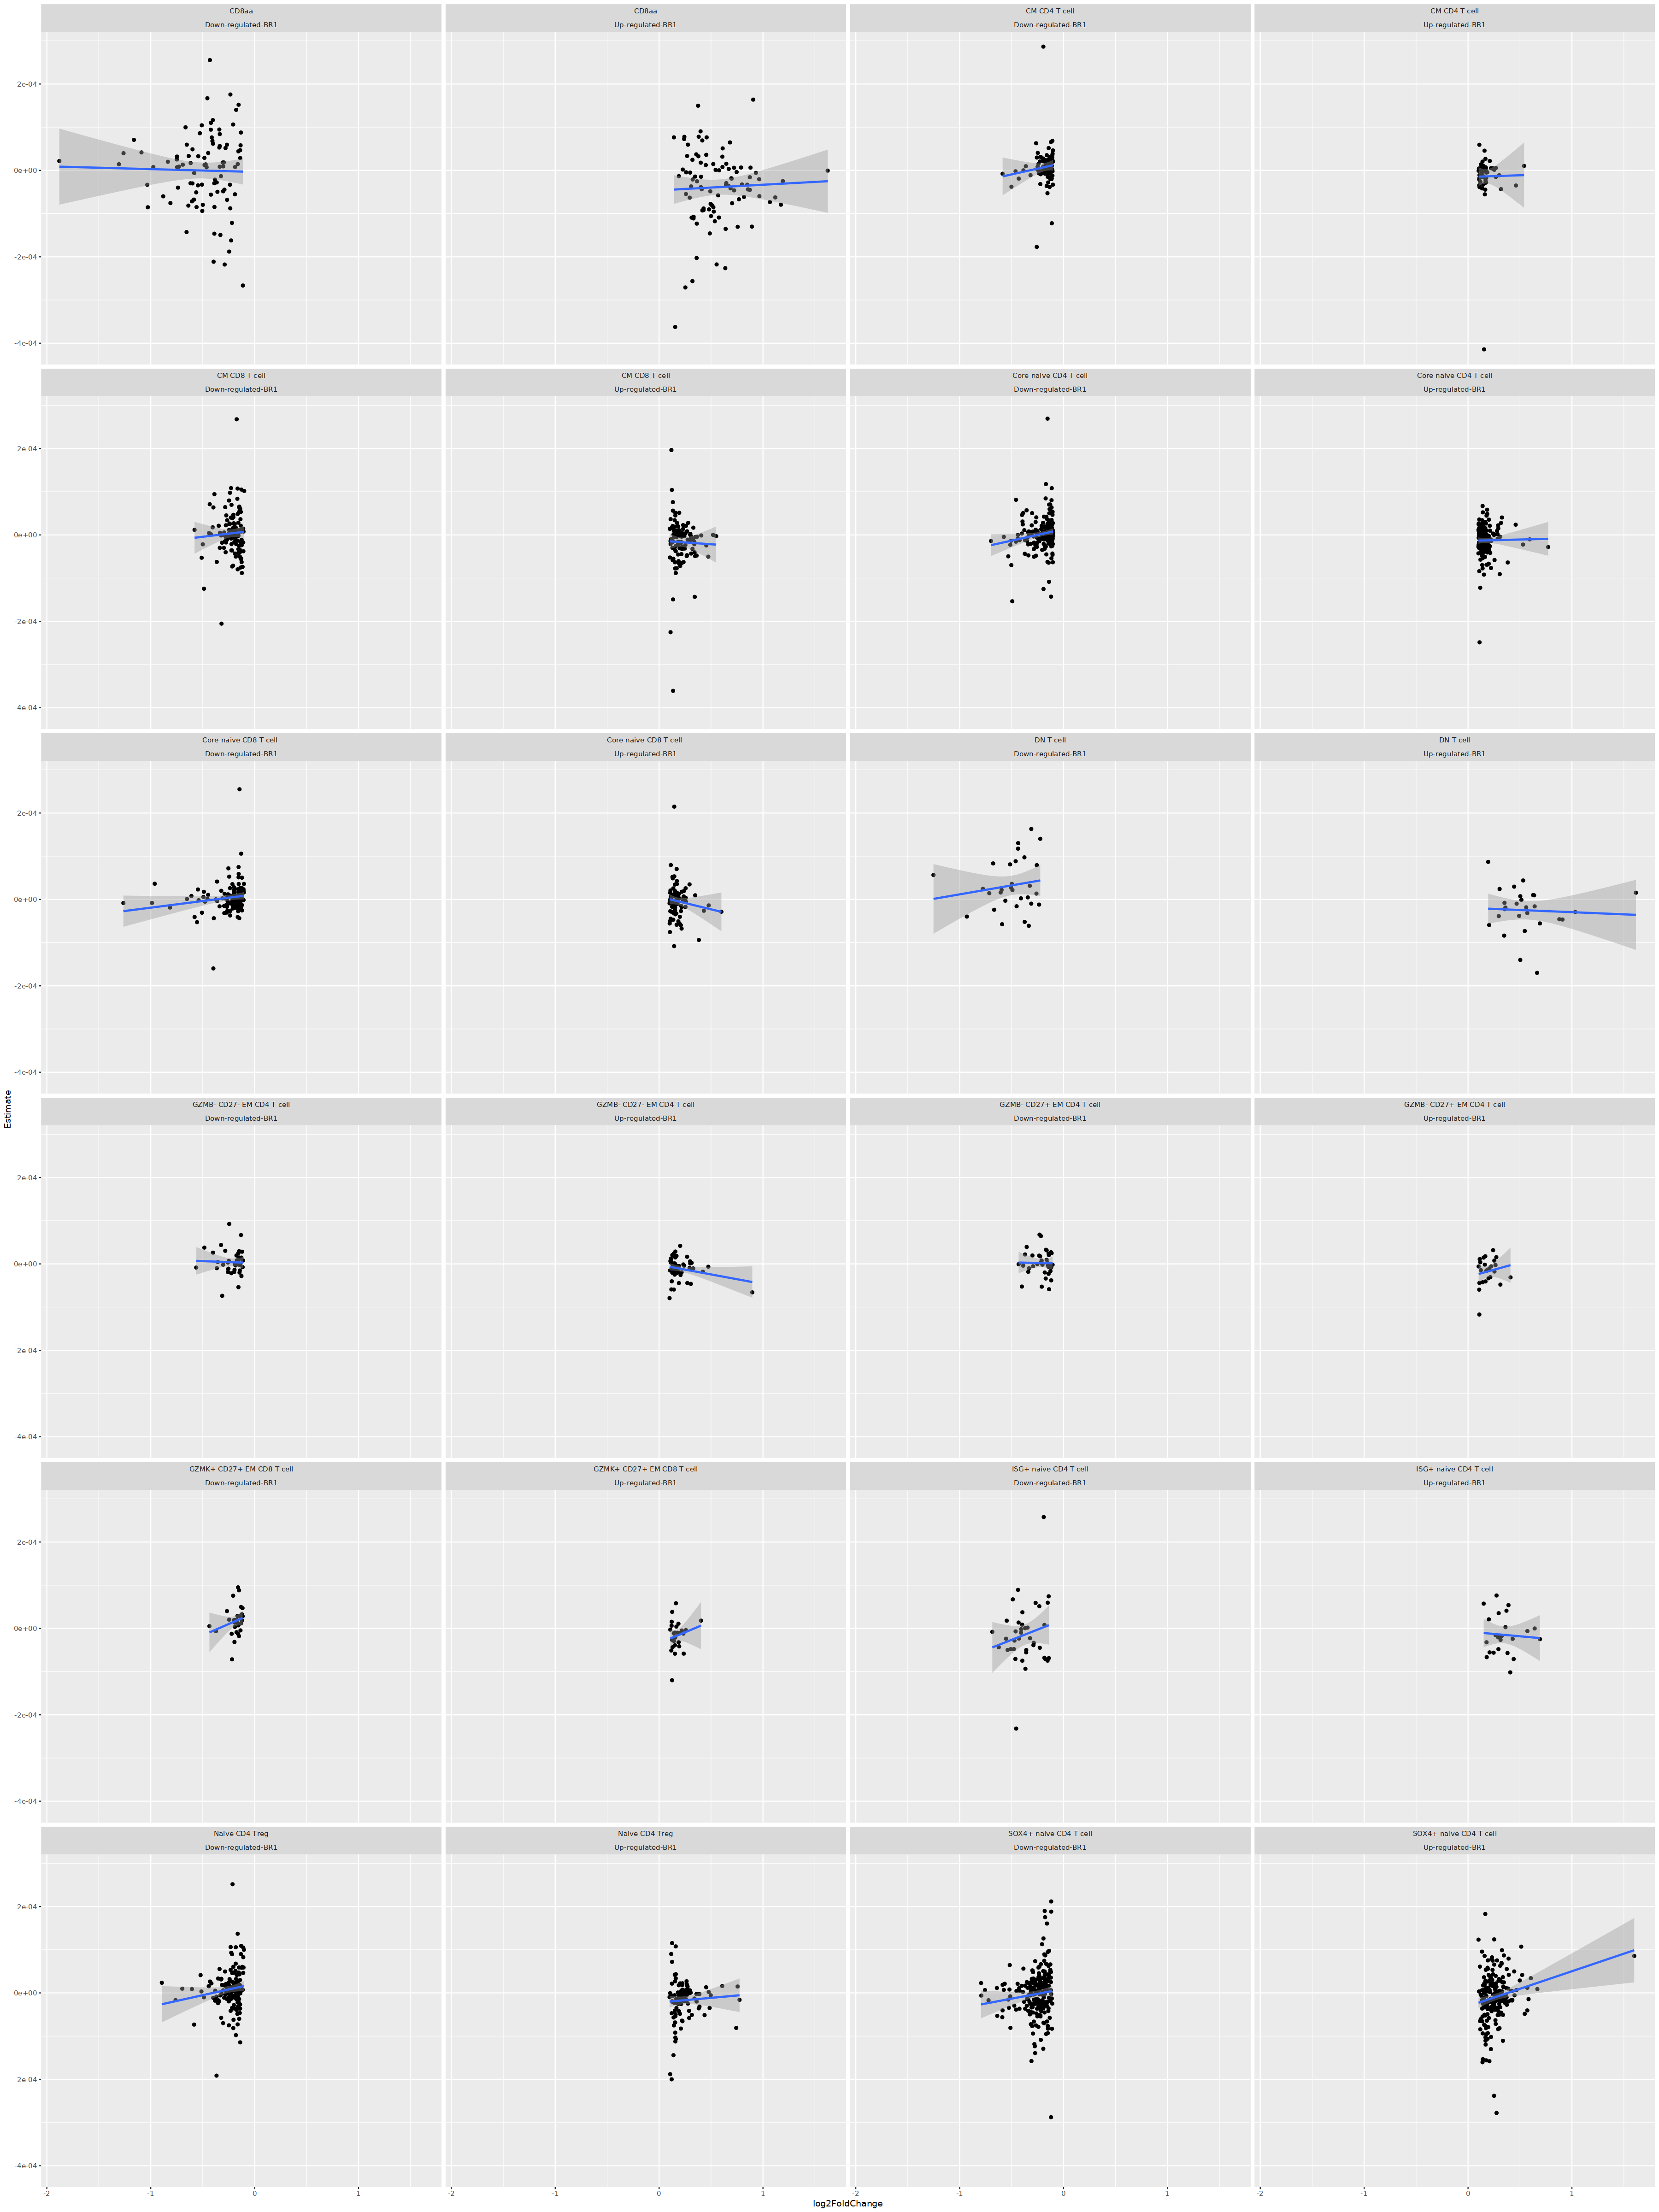

In [72]:
options(repr.plot.width = 30, repr.plot.height = 40)

ggplot(data = DEG_filtered %>% filter(celltype %in% selected_celltype), aes(x = log2FoldChange, y =Estimate )) + 
  geom_point() +
  geom_smooth(method = "lm", se = TRUE)+facet_wrap(~celltype+Expression, ncol=4)

# LMM result- BR1 VS BR2

In [5]:
file_list<-list.files(path ='/home//jupyter/BRI_Analysis/scRNA/Analysis-Longitudinal_Baselines/04C_LMM_Time_BR1_OR_BR2', pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)

In [6]:
LMM_list<-mclapply(file_list,function(x){

df<-read.csv(x)
df$cohorts<-substr(x,nchar(x) - 6, nchar(x)-4)
return(df)
},mc.cores=length(file_list))


In [7]:
LMM_res<-do.call(rbind,LMM_list) %>%
  filter(factor == 'sample.daysSinceFirstVisit') %>%
  group_by(celltype,cohorts) %>%
  mutate(padj = p.adjust(`Pr...t..`, method = 'BH')) 
LMM_res$p.normal<-LMM_res$`Pr...t..`

In [8]:
LMM_res$Estimate<-as.numeric(LMM_res$Estimate)

In [10]:
write.csv(LMM_res,"LMM_res.csv")

### Volcano Plots

In [13]:
LMM_res %>%filter(Gene=="LGALS1",padj<0.05)

X,Estimate,Std..Error,df,t.value,Pr...t..,Gene,celltype,factor,cohorts,padj,p.normal
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
2,-1.906815e-04,5.800648e-05,278.7754,-3.287245,1.141405e-03,LGALS1,CD27- effector B cell,sample.daysSinceFirstVisit,BR1,6.848428e-03,1.141405e-03
214,-7.371467e-05,2.238367e-05,266.1371,-3.293234,1.124566e-03,LGALS1,CM CD4 T cell,sample.daysSinceFirstVisit,BR1,3.131144e-03,1.124566e-03
246,-6.885796e-05,2.104003e-05,262.7952,-3.272711,1.207887e-03,LGALS1,CM CD8 T cell,sample.daysSinceFirstVisit,BR1,4.954384e-03,1.207887e-03
2,-1.135064e-04,2.182956e-05,264.5567,-5.199665,4.000172e-07,LGALS1,Core memory B cell,sample.daysSinceFirstVisit,BR1,4.600197e-06,4.000172e-07
1270,-3.108749e-05,6.936716e-06,273.6941,-4.481586,1.090085e-05,LGALS1,Core naive CD4 T cell,sample.daysSinceFirstVisit,BR1,6.968756e-05,1.090085e-05
270,-1.804297e-04,4.461013e-05,269.7029,-4.044590,6.847557e-05,LGALS1,GZMB- CD27- EM CD4 T cell,sample.daysSinceFirstVisit,BR1,6.046233e-04,6.847557e-05
270,7.123713e-05,3.854809e-05,266.6919,1.848007,6.570847e-02,LGALS1,GZMB- CD27- EM CD4 T cell,sample.daysSinceFirstVisit,BR2,1.733974e-01,6.570847e-02
42,-1.091451e-04,2.550782e-05,264.7485,-4.278888,2.626914e-05,LGALS1,GZMB- CD27+ EM CD4 T cell,sample.daysSinceFirstVisit,BR1,1.654956e-04,2.626914e-05
42,-1.529233e-04,4.253793e-05,273.6571,-3.594987,3.847010e-04,LGALS1,GZMK- CD27+ EM CD8 T cell,sample.daysSinceFirstVisit,BR1,1.795271e-03,3.847010e-04


In [548]:
pdf("volcano_plots_LMM_BR1_BR2.pdf", width = 10, height = 4)

for (celltype_single in unique(LMM_res$celltype)) {
filtered_data <- LMM_res %>% filter(celltype == celltype_single)%>% mutate(Expression = case_when(Estimate >0 & padj <=  0.05 ~ "Up-regulated_along_time",
                                                     Estimate < 0 & padj <=  0.05 ~ "Down-regulated_along_time",
                                                     TRUE ~ "Unchanged"))
top <- 20

top_genes<-filtered_data %>% group_by(Expression,cohorts)  %>% 
    arrange(padj, desc(abs(Estimate)))%>% filter(!Expression=="Unchanged")%>% 
    slice_head(n=top) 
    

  if (nrow(filtered_data) > 0) {
   p <- ggplot(filtered_data , 
                aes(x = Estimate, 
                    y = -log(padj,10), 
                    color = Expression,
                    label = Gene)) +
      geom_point(size = 0.5) +geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=25,
                   mapping = aes(Estimate, -log(padj,10), label = Gene),
                   size = 3)+
      facet_wrap(~cohorts) +
  xlab(expression("Estimate")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated_along_time"="dodgerblue3", "Unchanged"="gray50", "Up-regulated_along_time"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=8)))+
      theme_bw(base_size = 8)+ggtitle(celltype_single)
    print(p)
  }
}

dev.off()

Warning message:
“ggrepel: 15 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 26 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 14 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

### Stacked Barplots

In [12]:
LMM_res<-LMM_res[c('Estimate','Gene','celltype','padj','p.normal','cohorts')]

In [13]:
LMM_res_BR1<-LMM_res %>% filter(cohorts=="BR1")
LMM_res_BR2<-LMM_res %>% filter(cohorts=="BR2")

In [14]:
colnames(LMM_res_BR1)<-c('Estimate_BR1','Gene','celltype','padj_BR1','p.normal_BR1','cohorts')
colnames(LMM_res_BR2)<-c('Estimate_BR2','Gene','celltype','padj_BR2','p.normal_BR2','cohorts')

In [15]:
df<-left_join(LMM_res_BR1[c('Estimate_BR1','Gene','celltype','padj_BR1','p.normal_BR1')],LMM_res_BR2[c('Estimate_BR2','Gene','celltype','padj_BR2','p.normal_BR2')])

Joining with `by = join_by(Gene, celltype)`


In [16]:
df<- df%>% mutate(Expression = case_when(Estimate_BR1 > 0 & padj_BR1 <=  0.05&  Estimate_BR2 > 0 & padj_BR2 <=  0.05~ "Increasing within both",
                                         Estimate_BR1 < 0 & padj_BR1 <=  0.05&  Estimate_BR2 < 0 & padj_BR2 <=  0.05~ "Decreasing within both",
                                         Estimate_BR1 > 0 & padj_BR1 <=  0.05&  Estimate_BR2 < 0 & padj_BR2 <=  0.05~ "Increasing-BR1/Decreasing-BR2",
                                         Estimate_BR1 < 0 & padj_BR1 <=  0.05&  Estimate_BR2 > 0 & padj_BR2 <=  0.05~ "Decreasing-BR1/Increasing-BR2",
                                         Estimate_BR1 < 0 & padj_BR1 <=  0.05&  padj_BR2 >  0.05~ "Decreasing-BR1/Unchanged-BR2",
                                         Estimate_BR1 > 0 & padj_BR1 <=  0.05&  padj_BR2 >  0.05~ "Increasing-BR1/Unchanged-BR2",                                         
                                         Estimate_BR2 < 0 & padj_BR2 <=  0.05&  padj_BR1 >  0.05~ "Unchanged-BR1/Decreasing-BR2",
                                         Estimate_BR2 > 0 & padj_BR2 <=  0.05&  padj_BR1 >  0.05~ "Unchanged-BR1/Increasing-BR2",
                                                     TRUE ~ "Unchanged within both"))


In [18]:
write.csv(df,"df_LMM_res.csv")

In [451]:
color_list <- setNames(pal_d3("category10")(9), unique(df$Expression))

In [452]:
options(repr.plot.width = 14, repr.plot.height = 10)

pdf("output_plots.pdf", width = 14, height = 10)

for (celltype_single in unique(df$celltype)) {
  filtered_data <- df %>% filter(celltype == celltype_single, Expression != 'Unchanged')

  if (nrow(filtered_data) > 0) {
    p <- ggplot(filtered_data, 
                aes(x = Estimate_BR1, 
                    y = Estimate_BR2, 
                    color = Expression,
                    label = Gene)) +
      geom_hline(yintercept = 0) +
      geom_vline(xintercept = 0) +
      geom_point(size = 1) +
      facet_wrap(~celltype) + 
      scale_color_manual(values = color_list) +
      geom_text_repel(box.padding = 0.5, force = 0.5, max.overlaps = 25) +
      theme_bw(base_size = 20)

    print(p)
  }
}

dev.off()


Warning message:
“ggrepel: 18 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 122 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 186 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 301 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 152 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 23 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 163 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 319 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

### barplots

In [453]:
df_barplots<-as.data.frame(table(df$Expression,df$celltype)) %>% filter(!Freq==0) %>% arrange(desc(Freq))

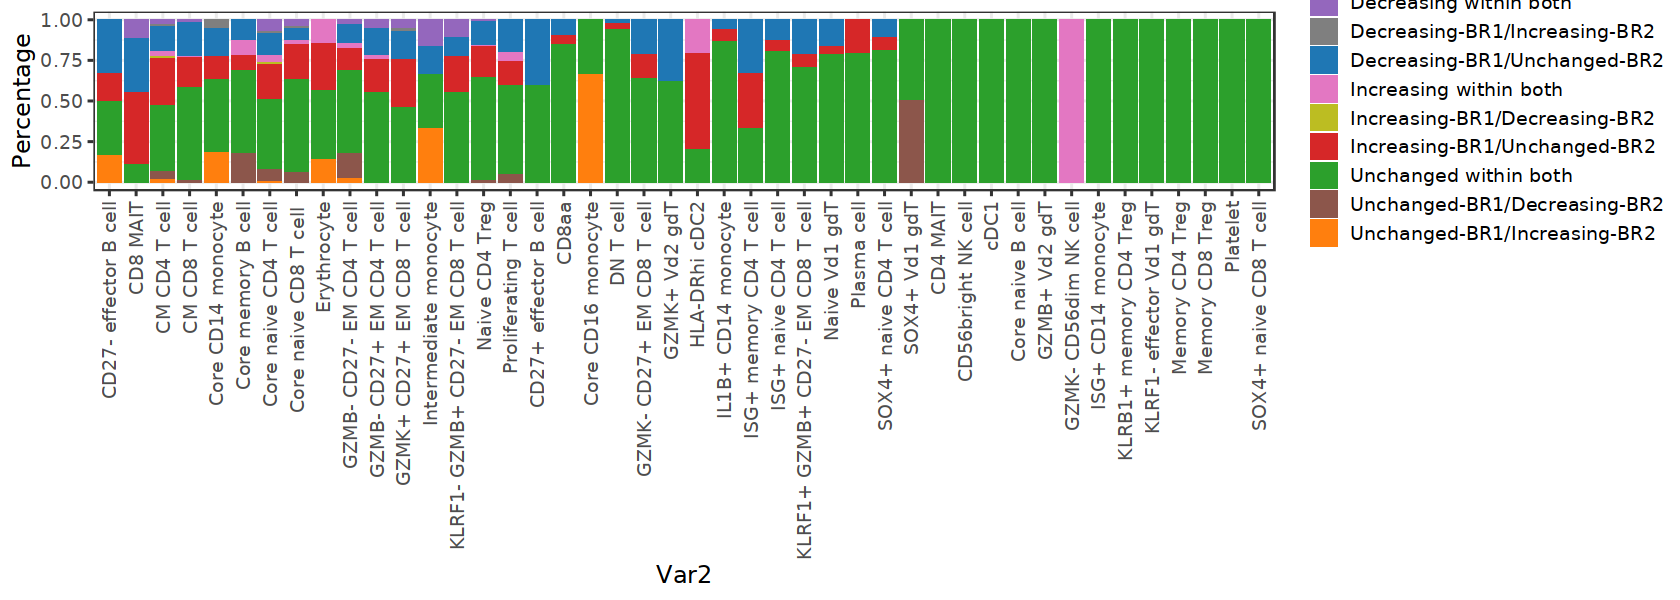

In [454]:
options(repr.plot.width = 14, repr.plot.height = 5)

df_barplots <- df_barplots %>%
  group_by(Var2) %>%
  mutate(TotalFreq = sum(Freq),
         Percentage = Freq / TotalFreq) %>%
  ungroup()


df_agg <- df_barplots %>%
  group_by(Var2) %>%
  summarise(AvgPercentage = mean(Percentage))  

dissimilarity <- dist(df_agg$AvgPercentage)
hc <- hclust(dissimilarity, method = "ward.D2")

k <- 3
clusters <- cutree(hc, k)

df_agg$Cluster <- as.factor(clusters)

df_barplots <- df_barplots %>%
  left_join(df_agg[, c("Var2", "Cluster")], by = "Var2")

df_barplots$Var2 <- factor(df_barplots$Var2, levels = df_agg$Var2[order(df_agg$Cluster)])

p1<-ggplot(df_barplots, aes(fill=Var1, y=Percentage, x=Var2)) + 
  geom_bar(position="fill", stat="identity") + 
  scale_fill_manual(values = color_list) +theme_bw(base_size=14)+
  labs(x="Var2", y="Percentage")+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p1

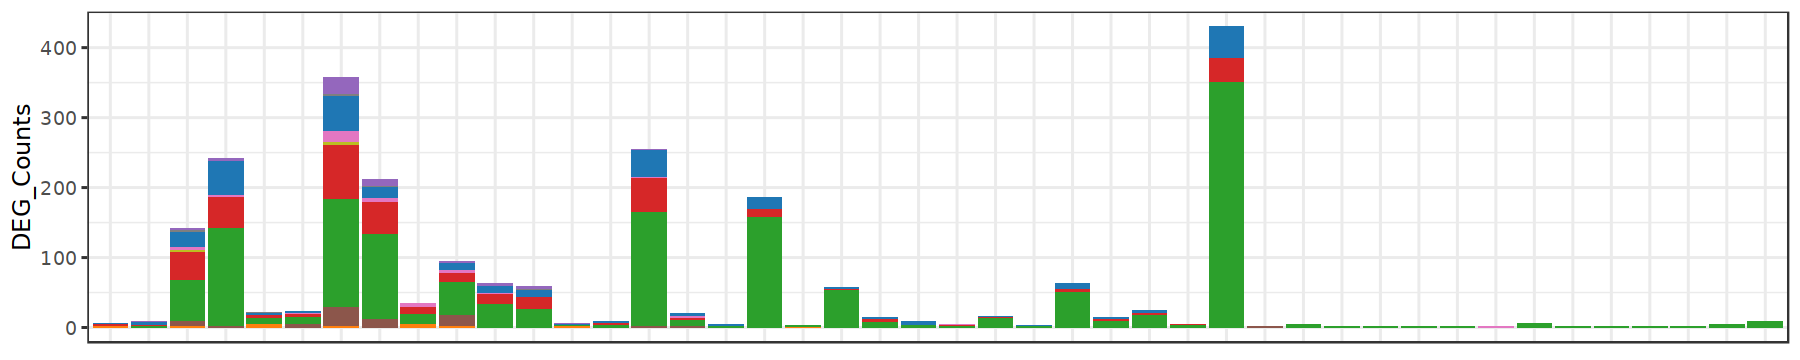

In [455]:
options(repr.plot.width = 15, repr.plot.height = 3)

p2<-ggplot(df_barplots, aes(fill=Var1, y=Freq, x=Var2)) + 
  geom_col() + 
  scale_fill_manual(values = color_list) +theme_bw(base_size=14)+
  labs(x="Var2", y="DEG_Counts")+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())+ guides(fill="none", color="none")
p2

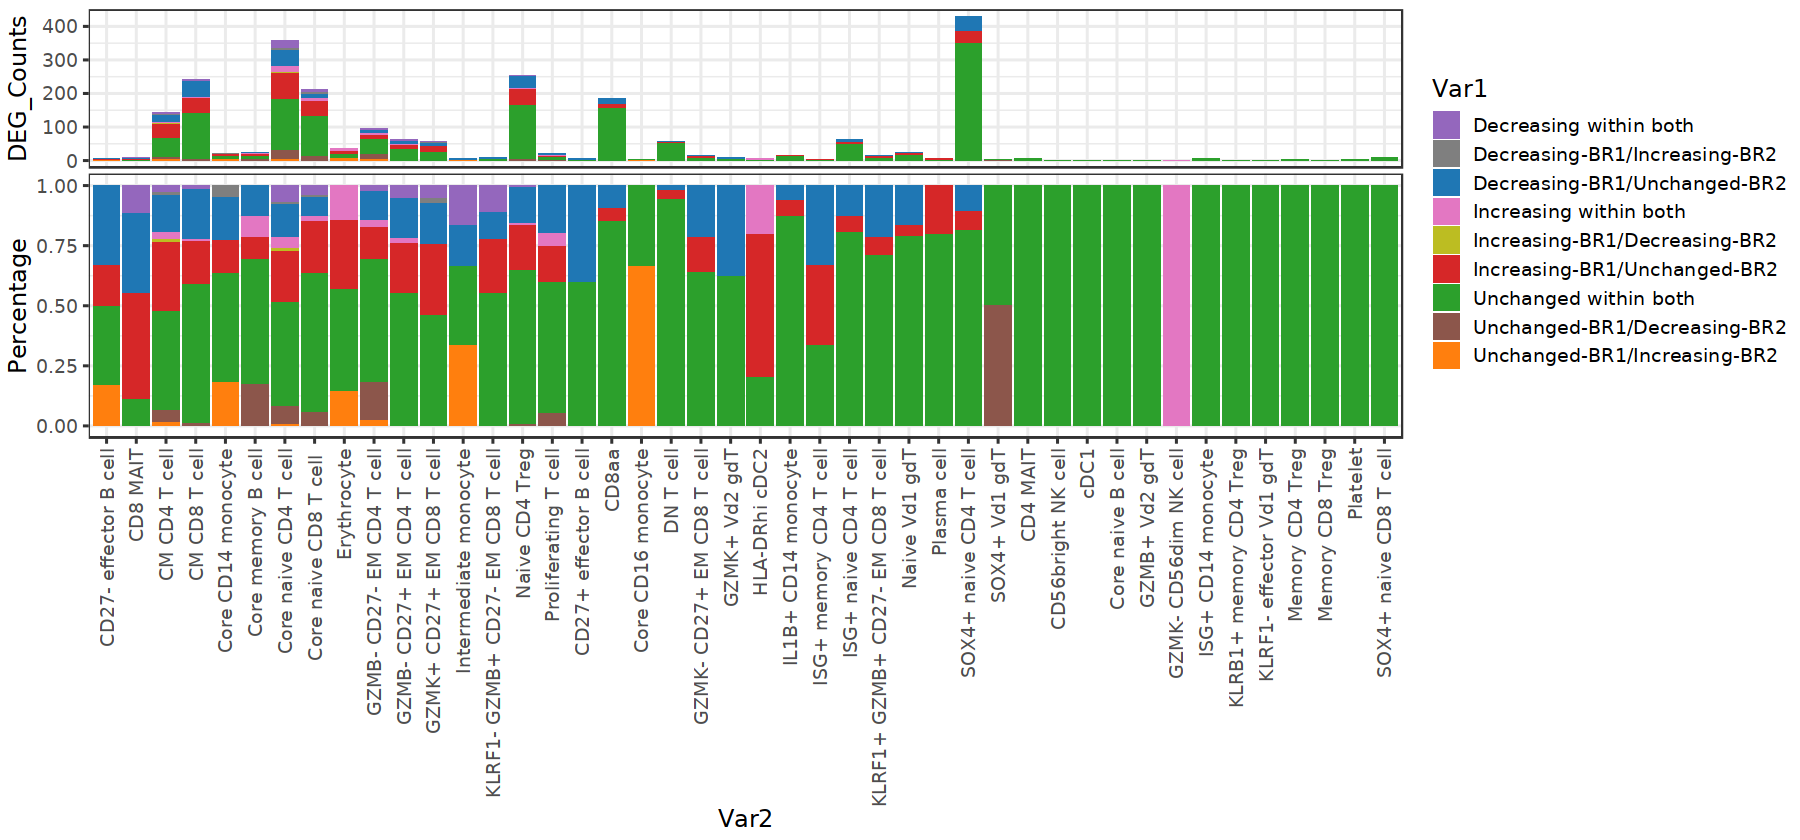

In [456]:
options(repr.plot.width = 15, repr.plot.height = 7)

p1%>% insert_top(p2,height=0.6) 

### heatmap

In [457]:
heatmap_counts<-as.data.frame(table(df$Expression,df$Gene)) %>% filter(Freq>0) %>% arrange(desc(Freq))

In [475]:
heatmap_counts %>% filter(Var2=="MALAT1")

Var1,Var2,Freq
<fct>,<fct>,<int>
Decreasing within both,MALAT1,2
Decreasing-BR1/Unchanged-BR2,MALAT1,2


In [466]:
heatmap_counts<-heatmap_counts %>% filter(!Var1=='Unchanged within both')

In [494]:
selected_genes<-heatmap_counts %>% filter(Freq>3) %>% select(Var2) %>% pull()

In [495]:
heatmap_counts_wide <- as.data.frame(pivot_wider(heatmap_counts%>% filter(Var2 %in% selected_genes), names_from = Var1, values_from = Freq))

In [496]:
heatmap_counts_wide[is.na(heatmap_counts_wide)] <- 0

In [497]:
rownames(heatmap_counts_wide)<-pull(heatmap_counts_wide['Var2'])

In [498]:
heatmap_counts_wide<-heatmap_counts_wide[-1]

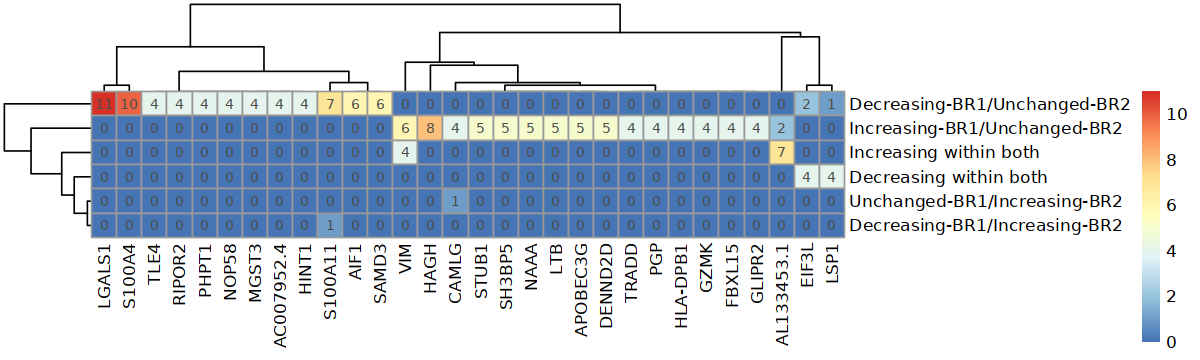

In [500]:
options(repr.plot.width = 10 ,repr.plot.height = 3)
library(viridis)

pheatmap(t(heatmap_counts_wide),display_numbers=TRUE, angle_col = 90,number_format = "%.0f")
